### Motivation and theory

Our aim is to calculate the expectation value and variance of the last layer with activity in a feedforward, layered network as a function of strenth of the weights and the probability of connection between two neurons. This calculation is intended to address a scenario in which connections between neurons have been removed at random, leaving the network in state where the connection probability between two neurons in successive layers is $p_c$.

We begin by assuming connectivity between two successive layers is independent of the connectivity between any other two successive layers. Then the probability of activity terminating at the $m^{th}$ layer is

$$p(m) = (p_l)^m (1 - p_l)$$

where $p_l$ is the probability activity propagates from one layer to the next. We will consider activity as having successively propagated if $p_{t}$ fraction of neurons are active in the subsequent layer. We then have

$$p_l = 1 - \Phi_{1-p_n}(n - n p_{t}, n p_{t} + 1) $$,

where $p_n$ is the probability a single neuron becomes active given a fully active prior layer and where we have used the identity

$$P(X \le k) = \Phi_{1-p}(n - k, k + 1)$$

where $X$ is a binomially distributed random variable of $n$ trials.

We now specify $p_n$ as

$$p_n = 1 - \Phi_{1-p_c}\left(n - \frac{V_{0}}{w}, \frac{V_{0}}{w} + 1\right) $$

where $V_{0}$ is the voltage threshold and $w$ is the strength of all synapses.

We now compute the expectation and variance of final layer with activity in a network of $n_l$ layers. 

$$\mathbb{E}(m) = \sum_{l=1}^{n_l} m \, p(m)$$

$$\mathbb{V}(m) = \sum_{l=1}^{n_l} m^2 p(m)$$

### Computation

In [1]:
%matplotlib inline
from scipy.special import betainc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def bin_occurrences(occurrences, min_val=0, max_val=None, bin_size=1):
    scaled_occurrences = ((occurrences - min_val) / bin_size).astype(int)

    if max_val is None:
        max_val = occurrences.max()

    max_idx = int(np.ceil((max_val - min_val) / bin_size)) + 1

    binned = np.zeros(max_idx, dtype=int)
    for i, n in enumerate(scaled_occurrences):
        if n >= max_idx or n < 0:
            continue
            # raise IndexError(f'val {occurrences[i]} is out of bounds for min {min_val} and max {max_val}')
        binned[n] += 1
    return np.arange(max_idx) * bin_size + min_val, binned

In [3]:
layer_width = 20
n_layers = 30

In [146]:
def sim_markov_chain(n_iters, beta=-0.05, std_beta=0.02, alpha=0.1, s=0.02):
    betas = np.random.normal(loc=beta, scale=std_beta, size=n_layers)
    p_transitions = 1 / (1 + np.exp(-betas / s)) * np.ones((n_iters, n_layers))
    n_visits = np.zeros((n_iters, n_layers))
    failure_points = np.zeros(n_iters)
    
    for i in range(n_iters):
        k = 0
        while k < n_layers and np.random.rand() < p_transitions[i, k]:
            n_visits[i, k] += 1
            if i < n_iters - 1:
                p_transitions[i+1, k] = 1 / (1 + np.exp(-(alpha * n_visits[i, k] + betas[k]) / s))
            k += 1
        
        failure_points[i] = k
            
        if i < n_iters - 1:
            n_visits[i+1, :] = n_visits[i, :]
    return p_transitions, n_visits, failure_points

def sim_markov_chain_autonomous(n_iters, beta=-0.05, std_beta=0.1, alpha=0.001, s=0.02):
    betas = np.random.normal(loc=beta, scale=std_beta, size=n_layers)
    p_transitions = 1 / (1 + np.exp(-betas / s)) * np.ones((n_iters, n_layers))
    n_visits = np.zeros((n_iters, n_layers))
    failure_points = np.zeros(n_iters)
    
    for i in range(n_iters):
        k = 0
        while k < n_layers and np.random.rand() < p_transitions[i, k]:
            n_visits[i, k] += 1
            k += 1
        
        if i < n_iters - 1:
            p_transitions[i+1, :] = 1 / (1 + np.exp(-(alpha * i + betas) / s))
        
        failure_points[i] = k
            
        if i < n_iters - 1:
            n_visits[i+1, :] = n_visits[i, :]
    return p_transitions, n_visits, failure_points

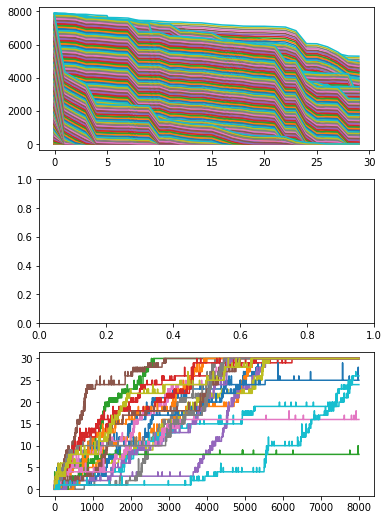

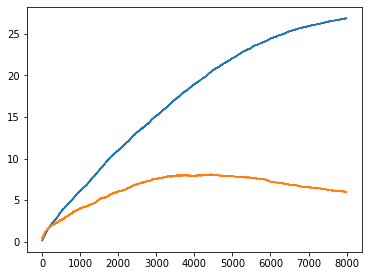

In [196]:
scale = 1.5
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(4 * scale, 6 * scale))

all_failure_points = []

for j in range(200):
    transitions, visits, failure_points = sim_markov_chain(8000, alpha=0.01, std_beta=0.025)
    all_failure_points.append(failure_points)
    if j % 10 == 0:
        for i in range(0, visits.shape[0], 100):
            axs[0].plot(np.arange(n_layers), visits[i, :])
        axs[2].plot(np.arange(visits.shape[0]), failure_points)

all_failure_points = np.array(all_failure_points)
    
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
axs.plot(np.arange(all_failure_points.shape[1]), np.mean(all_failure_points, axis=0))
axs.plot(np.arange(all_failure_points.shape[1]), np.std(all_failure_points, axis=0))

Text(0, 0.5, 'P(m)')

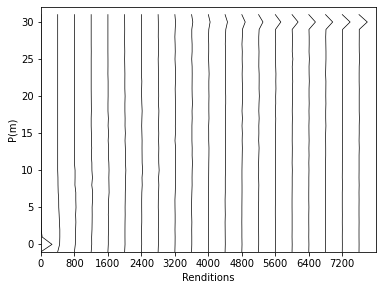

In [197]:
empirical_failure_probs = [bin_occurrences(all_failure_points[:, i].astype(int), min_val=-1, max_val=n_layers + 1)[1] for i in range(all_failure_points.shape[1])]
empirical_failure_probs = np.array(empirical_failure_probs)
empirical_failure_probs = empirical_failure_probs / np.sum(empirical_failure_probs, axis=1).reshape(8000, 1)

fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
for i in range(0, 8000, 400):
8axs.set_xticks(np.arange(0, 8000, 800))
axs.set_xticklabels(np.arange(0, 8000, 800))
axs.set_xlim(0, 8000)
axs.set_ylim(-1, n_layers + 2)
axs.set_xlabel('Renditions')
axs.set_ylabel('P(m)')

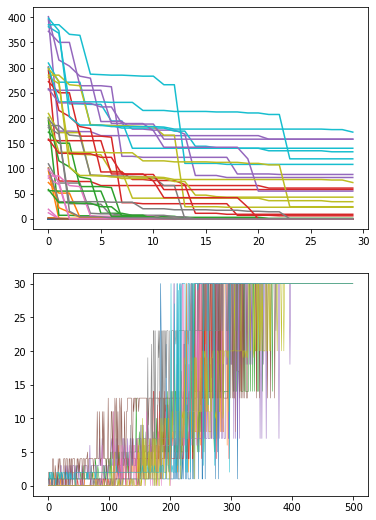

In [200]:
scale = 1.5
fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(4 * scale, 6 * scale))

all_failure_points = []

for j in range(1000):
    transitions, visits, failure_points = sim_markov_chain_autonomous(500, alpha=0.001, std_beta=0.1)
    all_failure_points.append(failure_points)
    if j < 10:
        for i in range(0, visits.shape[0], 100):
            axs[0].plot(np.arange(n_layers), visits[i, :])
        axs[1].plot(np.arange(visits.shape[0]), failure_points, lw=0.5)

all_failure_points = np.array(all_failure_points)
# axs[1].set_xlim(0, 30)

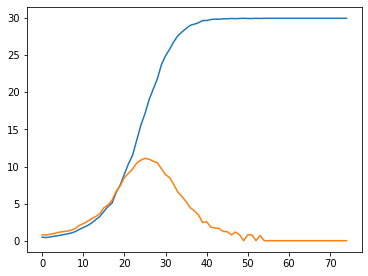

In [177]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
axs.plot(np.arange(all_failure_points.shape[1]), np.mean(all_failure_points, axis=0))
axs.plot(np.arange(all_failure_points.shape[1]), np.std(all_failure_points, axis=0))

Text(0, 0.5, 'P(m)')

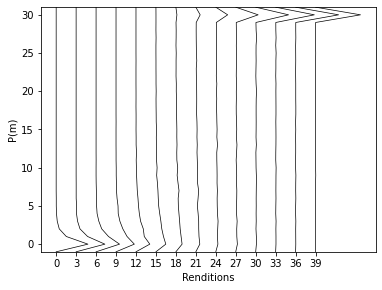

In [184]:
empirical_failure_probs = [bin_occurrences(all_failure_points[:, i].astype(int), min_val=-1, max_val=n_layers + 1)[1] for i in range(all_failure_points.shape[1])]
empirical_failure_probs = np.array(empirical_failure_probs)
empirical_failure_probs = empirical_failure_probs / np.sum(empirical_failure_probs, axis=1).reshape(75, 1)

fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
for i in range(0, 40, 3):
    axs.plot(i * np.ones(empirical_failure_probs.shape[1]) + 7 * empirical_failure_probs[i, :], np.arange(empirical_failure_probs.shape[1]) - 1, lw=0.7, color='black')
axs.set_xticks(np.arange(0, 40, 3))
axs.set_xticklabels(np.arange(0, 40, 3))
# axs.set_xlim(0, 20)
axs.set_ylim(-1, n_layers + 1)
axs.set_xlabel('Renditions')
axs.set_ylabel('P(m)')